In [3]:
#For installing libraries, if already installed do not: do not run this section

!pip install git+https://github.com/huggingface/transformers
!git clone https://github.com/huggingface/transformers
!pwd
%ls
%cd transformers
!python setup.py install
%cd ..
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-rmqpehq2
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-rmqpehq2
  Resolved https://github.com/huggingface/transformers to commit fe1f5a639d93c9272856c670cff3b0e1a10d5b2b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 57.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 27.2 MB/s eta 0:00:00
  Created wheel for transformers: filename=transformers-4.28.0.dev0-py3-none-any.whl size=6911605 sha256=4a0a1b7a07f85215a74f65e81000000752f95ed860404626ba696b7549d881e4
  Stored in directory: /tmp/pip-ephem-wheel-cache-dtxwfq_7/wheels/14/a0/7b/8f6b25ba4110aa215fcb8d6aedd6cd4f9b9b6619190

In [1]:
#only necessary for accessing drive file

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
from transformers import AutoFeatureExtractor, AutoImageProcessor, AutoModelForObjectDetection
import pytorch_lightning as pl
import torchvision.transforms as transforms
import torch
from PIL import Image
import requests

feature_extractor = AutoImageProcessor.from_pretrained("hustvl/yolos-small")
id2label = {0: 'plants', 1: 'daisy', 2: 'dandelion', 3: 'rose', 4: 'sunflower', 5: 'tulip'}

#model class
class Yolo(pl.LightningModule):

    def __init__(self, lr, lr_backbone, weight_decay, dict_label):
        super().__init__()
        self.model = AutoModelForObjectDetection.from_pretrained(
            pretrained_model_name_or_path="hustvl/yolos-small", 
            num_labels=len(id2label),
            ignore_mismatched_sizes=True
        )
        
        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def forward(self, pixel_values):
        return self.model(pixel_values=pixel_values)

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step, and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
            self.log("train_" + k, v.item())

        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("validation/loss", loss)
        for k, v in loss_dict.items():
            self.log("validation_" + k, v.item())
            
        return loss

    def configure_optimizers(self):
        # DETR authors decided to use different learning rate for backbone
        # you can learn more about it here: 
        # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L22-L23
        # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L131-L139
        param_dicts = [
            {
                "params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
            {
                "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                "lr": self.lr_backbone,
            },
        ]
        return torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)
#loads model
reload_model = Yolo.load_from_checkpoint("/content/drive/MyDrive/VIP-Spring 2023-Plant_Recognition/model.ckpt", lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4, dict_label=id2label).to("cuda")

#Beginning of object detection
url = '/content/drive/MyDrive/VIP-Spring 2023-Plant_Recognition/Data/flowers/daisy/5884807222_22f5326ba8_m.jpg'

image = Image.open(url)
transform = transforms.Compose([transforms.PILToTensor()])
tensor = transform(image).to("cuda")

inputs = feature_extractor(images=tensor, return_tensors="pt").to("cuda")
inputs = inputs.to("cuda")

outputs = reload_model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
target_sizes = torch.tensor([image.size[::-1]])
results = feature_extractor.post_process_object_detection(outputs, threshold=0.7, target_sizes=target_sizes)[0]

#String in form: "score label x1 y1 w h"
#new line -> another box was found
#(x1,y1) = top left
#(x2,y2) = bottom right
#w = x2-x1
#h = y2-y2
output_string = ""

#replace this with returning proper string
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )
    output_string += (f"{round(score.item(), 3)} {id2label[label.item()]} {box[0]} {box[1]} {round(box[2] - box[0], 2)} {round(box[3] - box[1], 2)}\n" )


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-small and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 384]) in the checkpoint and torch.Size([7, 384]) in the model instantiated
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Detected daisy with confidence 0.964 at location [168.75, 37.61, 216.9, 85.67]
Detected daisy with confidence 0.932 at location [118.86, 126.99, 160.62, 171.28]
Detected daisy with confidence 0.959 at location [91.99, 38.07, 152.56, 87.93]
Detected daisy with confidence 0.925 at location [46.23, 71.52, 98.34, 123.75]


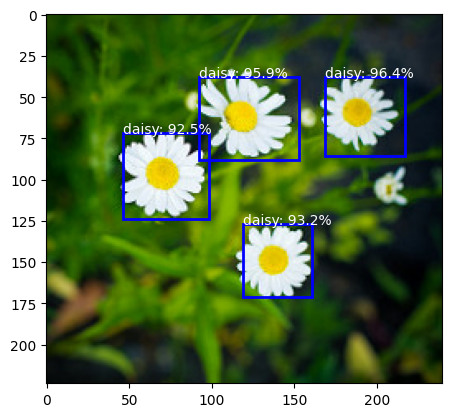

In [24]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Code to parse returned string | kwl 4/10/23

fig, ax = plt.subplots()
ax.imshow(image)
# Split string by newline character
for result in output_string.split("\n"):
  
  # Split each result by space
  values = result.split(" ")
#  print(values)
  try:
    score, label, x1, y1, w, h = float(values[0]), values[1], float(values[2]), float(values[3]), float(values[4]), float(values[5])

    # Creating and plotting rectangle + adding label
    rect = patches.Rectangle((x1, y1), w, h, linewidth = 2, edgecolor = 'b', facecolor = 'none')
    plt.text(x1, y1, f"{label}: {round(score * 100, 1)}%", fontdict = None, color = 'w')
    ax.add_patch(rect)
  # Splitting by newline creates an extra blank list element; loop breaks when we get to it
  except ValueError or IndexError:
    break

plt.show()